In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("dark")
plt.style.use('ggplot')

from sklearn.metrics import classification_report

/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Load data from train

In [2]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../data/data.db', echo=True)
conn = engine.connect()

df = pd.read_sql("SELECT * FROM train",conn)

2021-04-25 12:25:38,991 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-04-25 12:25:38,992 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 12:25:38,993 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-04-25 12:25:38,993 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 12:25:38,994 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT * FROM train")
2021-04-25 12:25:38,995 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 12:25:38,996 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT * FROM train")
2021-04-25 12:25:38,996 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 12:25:38,997 INFO sqlalchemy.engine.base.Engine SELECT * FROM train
2021-04-25 12:25:38,997 INFO sqlalchemy.engine.base.Engine ()


In [3]:
df.shape

(5698, 3)

In [4]:
df.label.value_counts()

824.company-brand.general-satisfaction.0                   2682
824.account-management.account-access.0                     847
824.company-brand.convenience.0                             799
824.online-experience.updates-versions.0                    565
824.company-brand.competitor.0                              520
824.account-management.fingerprint-facial-recognition.0     199
824.staff-support.agent-named.0                              32
824.staff-support.email.0                                    17
824.online-experience.language.0                             13
824.purchase-booking-experience.choice-variety.0             11
824.logistics-rides.speed.0                                   6
824.attributes.size-fit.0                                     3
824.logistics-rides.order-accuracy.0                          2
824.attributes.cleanliness.0                                  1
824.attributes.taste-flavour.0                                1
Name: label, dtype: int64

In [5]:
## remove the label < 20 posts
df = df[~df['label'].isin([
                      '824.staff-support.email.0',
                      '824.online-experience.language.0',
                      '824.purchase-booking-experience.choice-variety.0',
                      '824.logistics-rides.speed.0',
                      '824.attributes.size-fit.0',
                      '824.logistics-rides.order-accuracy.0',
                      '824.attributes.taste-flavour.0',
                      '824.attributes.cleanliness.0'])]

In [6]:
label_df = pd.merge(df['comment'],pd.get_dummies(df['label']),left_index=True, right_index=True)

In [7]:
print("Label number:", len(label_df.drop('comment',axis=1).columns))

Label number: 7


## 2. train-val split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, val = train_test_split(label_df,test_size=0.1,random_state=101)

In [10]:
train.shape, val.shape

((5079, 8), (565, 8))

## 3. Model Comparison

### 3.3 Transfer Learning: BERT

In [11]:
import tensorflow as tf
print('TF version',tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


from transformers import *
import tokenizers

def label_class(y):
    if y>0.5:
        return 1
    else:
        return 0

TF version 2.4.1


In [12]:
## tokenization

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [14]:
max_length = 200 

def tokenize(text):
    tokenized = tokenizer.encode_plus(text,
                                      truncation=True,
                                      add_special_tokens = True, 
                                      max_length = max_length, 
                                      pad_to_max_length = True, 
                                      return_attention_mask = True,
                                      return_token_type_ids=False,
                                      return_tensors='tf') 
    return tokenized['input_ids'], tokenized['attention_mask']

tokenize(train['comment'][1401])

/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
 array([[  101,  2204,  2021,  2823,  1996, 10439,  2003,  4895,  6072,
         26029, 12742,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

In [15]:
# initialize two arrays for input tensors
Xids = np.zeros((len(train), max_length))
Xmask = np.zeros((len(train), max_length))

# loop through data and tokenize everything
for i, sentence in enumerate(train['comment']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [16]:
# initialize two arrays for input tensors
test_Xids = np.zeros((len(val), max_length))
test_Xmask = np.zeros((len(val), max_length))

# loop through data and tokenize everything
for i, sentence in enumerate(val['comment']):
    test_Xids[i, :], test_Xmask[i, :] = tokenize(sentence)

In [17]:
ylabel = {'out'+str(i):train.iloc[:,i].values for i in range(1,8)}
ylabel

{'out1': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'out2': array([0, 0, 0, ..., 0, 1, 0], dtype=uint8),
 'out3': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'out4': array([0, 0, 1, ..., 0, 0, 0], dtype=uint8),
 'out5': array([1, 1, 0, ..., 1, 0, 1], dtype=uint8),
 'out6': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 'out7': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)}

In [18]:
# Create a fine-tune model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
embeddings = bert(input_ids, attention_mask=mask)[0]

x = GlobalMaxPool1D()(embeddings)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

out1 = Dense(1, activation='sigmoid',name = 'out1')(x)
out2 = Dense(1, activation='sigmoid',name = 'out2')(x)
out3 = Dense(1, activation='sigmoid',name = 'out3')(x)
out4 = Dense(1, activation='sigmoid',name = 'out4')(x)
out5 = Dense(1, activation='sigmoid',name = 'out5')(x)
out6 = Dense(1, activation='sigmoid',name = 'out6')(x)
out7 = Dense(1, activation='sigmoid',name = 'out7')(x)

multitask_model = Model(inputs=[input_ids,mask], outputs=[out1,out2,out3,out4,out5,out6,out7])

In [20]:
multitask_model.layers[2].trainable = False

In [21]:
multitask_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 200, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

In [22]:
multitask_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=tf.metrics.AUC())

In [24]:
hist = multitask_model.fit(
                    x={'input_ids': Xids, 'attention_mask': Xmask},
                    y=ylabel,
                    epochs=3, 
                    validation_split=0.1,
                    batch_size=32,
                    workers=8,
                    verbose=1
                    )

Epoch 1/3
143/143 [==============================] - 1173s 8s/step - loss: 1.4578 - out1_loss: 0.2574 - out2_loss: 0.0923 - out3_loss: 0.1933 - out4_loss: 0.2906 - out5_loss: 0.4379 - out6_loss: 0.1678 - out7_loss: 0.0185 - out1_auc: 0.9071 - out2_auc: 0.9366 - out3_auc: 0.9081 - out4_auc: 0.8572 - out5_auc: 0.8749 - out6_auc: 0.9453 - out7_auc: 0.9190 - val_loss: 1.4833 - val_out1_loss: 0.2602 - val_out2_loss: 0.1159 - val_out3_loss: 0.1946 - val_out4_loss: 0.2788 - val_out5_loss: 0.4320 - val_out6_loss: 0.1777 - val_out7_loss: 0.0241 - val_out1_auc: 0.9068 - val_out2_auc: 0.9059 - val_out3_auc: 0.8954 - val_out4_auc: 0.8702 - val_out5_auc: 0.8790 - val_out6_auc: 0.9344 - val_out7_auc: 0.6922
Epoch 2/3
143/143 [==============================] - 1124s 8s/step - loss: 1.4237 - out1_loss: 0.2554 - out2_loss: 0.0928 - out3_loss: 0.1922 - out4_loss: 0.2816 - out5_loss: 0.4233 - out6_loss: 0.1626 - out7_loss: 0.0157 - out1_auc: 0.9076 - out2_auc: 0.9407 - out3_auc: 0.9088 - out4_auc: 0.8678

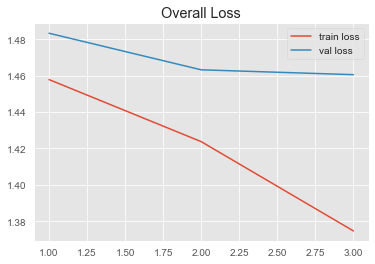

In [25]:
plt.title('Overall Loss')
plt.plot(range(1,4),hist.history['loss'])
plt.plot(range(1,4),hist.history['val_loss'])

plt.legend(['train loss','val loss'])

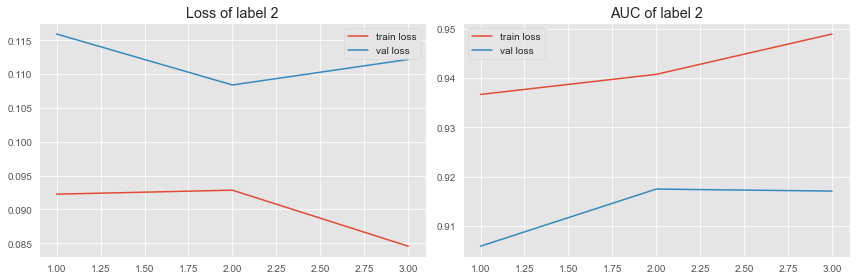

In [26]:
def plot_loss_and_auc(label_no):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axes[0].plot(range(1,4),hist.history['out'+str(label_no)+'_loss'])
    axes[0].plot(range(1,4),hist.history['val_out'+str(label_no)+'_loss'])
    axes[0].set_title(f'Loss of label {label_no}')
    axes[0].legend(['train loss','val loss'])
    axes[1].plot(range(1,4),hist.history['out'+str(label_no)+'_auc'])
    axes[1].plot(range(1,4),hist.history['val_out'+str(label_no)+'_auc'])
    axes[1].set_title(f'AUC of label {label_no}')
    axes[1].legend(['train loss','val loss'])
    fig.tight_layout()
    

plot_loss_and_auc(2)

In [ ]:
## prediction

In [27]:
prediction2 = multitask_model.predict({'input_ids': test_Xids, 'attention_mask': test_Xmask})
prediction2 = [[label_class(i) for i in p] for p in prediction2]
prediction2 = pd.DataFrame(prediction2).transpose()

In [28]:
print("Unweighted output:\n", classification_report(val.drop('comment',axis=1).values,
                                                    prediction2,
                                                   target_names=val.drop('comment',axis=1).columns)
     )

Unweighted output:
                                                          precision    recall  f1-score   support

                824.account-management.account-access.0       0.75      0.42      0.54        95
824.account-management.fingerprint-facial-recognition.0       0.25      0.14      0.18        14
                         824.company-brand.competitor.0       0.64      0.34      0.44        68
                        824.company-brand.convenience.0       0.62      0.53      0.57        72
               824.company-brand.general-satisfaction.0       0.72      0.85      0.78       269
               824.online-experience.updates-versions.0       0.81      0.68      0.74        44
                        824.staff-support.agent-named.0       0.00      0.00      0.00         3

                                              micro avg       0.70      0.64      0.67       565
                                              macro avg       0.54      0.42      0.46       565
        

/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
multitask_model.save("../models/bert/model",save_format='tf')

INFO:tensorflow:Assets written to: ../models/bert/model/assets


INFO:tensorflow:Assets written to: ../models/bert/model/assets
